In [1]:
#!pip uninstall tensorflow -y
!pip install tensorflow==2.13.0
!pip install transformers==4.31.0

   ---------------------------------------- 0.0/7.4 MB ? eta -:--:--
   ----- ---------------------------------- 1.0/7.4 MB 5.6 MB/s eta 0:00:02
   ------------ --------------------------- 2.4/7.4 MB 5.6 MB/s eta 0:00:01
   ------------------- -------------------- 3.7/7.4 MB 5.9 MB/s eta 0:00:01
   -------------------------- ------------- 5.0/7.4 MB 5.9 MB/s eta 0:00:01
   ---------------------------------- ----- 6.3/7.4 MB 5.9 MB/s eta 0:00:01
   ---------------------------------------- 7.4/7.4 MB 5.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/3.5 MB ? eta -:--:--
   --------------- ------------------------ 1.3/3.5 MB 6.7 MB/s eta 0:00:01
   --------------------------- ------------ 2.4/3.5 MB 6.1 MB/s eta 0:00:01
   ---------------------------------------- 3.5/3.5 MB 5.9 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.2
    Uninstalling tokenizers-0.20.2:
      Successfully uninstalled tokenizers-0.20.2
  Attem

  You can safely remove it manually.


In [30]:
import numpy as np
import pandas as pd

import os

#from skimage import io
#import os

import tensorflow as tf
import keras
import numpy as np
import pandas as pd

import matplotlib as mpl

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import itertools
import pathlib
import PIL
import time
import datetime
import random
import shutil
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Layer, Flatten
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import transformers

In [31]:
tf.__version__

'2.13.0'

In [32]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
device_name = tf.test.gpu_device_name()
print(device_name)
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
PATH = pathlib.Path.cwd()
print(PATH)

In [35]:
# track training start time and number of epochs completed
class TrainingStatsCallback(Callback):  
    def on_train_begin(self, logs=None):  
        self.start_time = time.time()
        self.epochs_trained = 0

    def on_epoch_end(self, epoch, logs=None):
        self.epochs_trained += 1

In [36]:
# returns train, validation and test datasets by randomly
# splitting each class folder of the 20 UK garden birds dataset
import stat

def get_data(dataset_path):    
    train_ds = (dataset_path.parent / "Final_Train").absolute()
    validation_ds = (dataset_path.parent / "Final_Validation").absolute()
    test_ds = (dataset_path.parent / "Final_Test").absolute()

    # Clear the train, validation, and test directories if they already exist
    for path in [train_ds, validation_ds, test_ds]:
        if path.exists():
            shutil.rmtree(path)

    # Create the train, validation, and test directories
    for path in [train_ds, validation_ds, test_ds]:
        path.mkdir(parents=True, exist_ok=True)
        os.chmod(path, 0o777)

    # Set the split ratios
    train_ratio = 0.7
    valid_ratio = 0.1
    test_ratio = 0.2

    # Iterate through each item in the dataset
    for item in os.listdir(dataset_path):
        item_path = os.path.join(dataset_path, item)

        # Check if the item is a directory and not named "birds.csv"
        if os.path.isdir(item_path) and item != "birds.csv":
            # Create subdirectories in the train, validation, and test sets for each class
            os.makedirs(os.path.join(train_ds, item), exist_ok=True)
            os.makedirs(os.path.join(validation_ds, item), exist_ok=True)
            os.makedirs(os.path.join(test_ds, item), exist_ok=True)

            # Get the list of image files in the current class subfolder
            image_files = os.listdir(item_path)

            # Perform Random Shuffle
            random.shuffle(image_files)

            # Calculate the number of samples for each split
            num_samples = len(image_files)
            num_train = int(train_ratio * num_samples)
            num_valid = int(valid_ratio * num_samples)
            num_test = int(test_ratio * num_samples)

            # Split the image files and move them to the corresponding subdirectories
            train_files = image_files[:num_train]
            valid_files = image_files[num_train:num_train + num_valid]
            test_files = image_files[num_train + num_valid:]

            
            original_perms = {folder: stat.S_IMODE(os.stat(folder).st_mode) for folder in  [train_ds, validation_ds, test_ds, item_path]}
            for folder in original_perms.keys():
                os.chmod(folder, 0o777)
            
            datasets = {
                "train": (train_ds, train_files),
                "validation": (validation_ds, valid_files),
                "test": (test_ds, test_files)
            }
            
            for ds_name, (ds_path, files) in datasets.items():
                for file in files:
                    src = os.path.join(item_path, file)
                    dst = os.path.join(ds_path, item, file)
                    shutil.copy(src, dst)
            
            for folder, original_perm in original_perms.items():
                os.chmod(folder, original_perm)


    return os.path.abspath(train_ds), os.path.abspath(validation_ds), os.path.abspath(test_ds)

In [37]:
def get_train_duration():
    #Calculate the training time and retrieve the number of epochs trained.
    duration_seconds = time.time() - training_stats_callback.start_time 
    duration = datetime.timedelta(seconds=duration_seconds)
    hours = duration.seconds // 3600
    minutes = (duration.seconds % 3600) // 60
    seconds = duration.seconds % 60
    
    epochs_trained = training_stats_callback.epochs_trained   
    return hours, minutes, seconds, epochs_trained

def show_training_plots(history): 
    # display a grid of the accuray and loss training plots
    mpl.rcParams['figure.figsize'] = (12, 10)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    metrics = ['accuracy','loss']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch[:len(history.history[metric])], history.history[metric], color=colors[1], label='Train')
        plt.plot(history.epoch[:len(history.history['val_'+metric])], history.history['val_'+metric],
                     color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)

        plt.legend()

In [38]:
def get_predictions(model,ds):
    #make predictions on the given dataset and print a classification report
    y_val = ds.classes
    y_pred = model.predict(ds)
    y_pred = np.argmax(y_pred,axis=1)
    class_indices = ds.class_indices
    indices = {v:k for k,v in class_indices.items()}
    filenames = ds.filenames
    print(classification_report(y_val,y_pred, zero_division=1))
    return indices, filenames, y_val, y_pred

def get_predictions_df(indices, filenames, y_val, y_pred):  
    #create a dataframe of predictions 
    test_df = pd.DataFrame()
    test_df['filename'] = filenames
    test_df['actual'] = y_val
    test_df['predicted'] = y_pred
    test_df['actual'] = test_df['actual'].apply(lambda x: indices[x])
    test_df['predicted'] = test_df['predicted'].apply(lambda x: indices[x])
    test_df.loc[test_df['actual']==test_df['predicted'],'Same'] = True
    test_df.loc[test_df['actual']!=test_df['predicted'],'Same'] = False
    test_df = test_df.sample(frac=1).reset_index(drop=True)
    
    # Write DataFrame to a CSV file    
    test_df.to_csv('predictions.csv', index=False)  # Change the filename as desired
    print(test_df)
    
    # Create and display the confusion matrix
    confusion_matrix_array = confusion_matrix(test_df['actual'], test_df['predicted'])
    confusion_matrix_df = pd.DataFrame(confusion_matrix_array, index=indices.values(), columns=indices.values())

    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix_df, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()
    
    return test_df

In [39]:
def readImage(path):
    #load image, covert to NumPy array and normalise
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    return img


def get_max_true_img():
    #returns the number of True predictions from test_df to display, MAX = 20
    max_true = len(test_df[test_df['Same']==True])
    if max_true > 20:
        max_true = 20 
    return max_true

def get_max_false_img():
    #returns the number of False predictions from test_df to display, MAX = 20
    max_true = len(test_df[test_df['Same']==False])
    if max_true > 20:
        max_true = 20 
    return max_true


def display_images(ds,temp_df, num_img):
    # display a grid of images from a dataframe with their actual and predicted lables 
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(num_img):
        n+=1
        plt.subplot(4 , 5, n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        image = readImage(os.path.join(ds, temp_df.filename[i]))
        plt.imshow(image)
        plt.title(f'A: {temp_df.actual[i]} P: {temp_df.predicted[i]}')

In [40]:
#source code modified  from https://www.kaggle.com/code/quadeer15sh/grad-cam-what-do-cnns-see/notebook
def make_gradcam_heatmap(img_array, model, pred_index=None):
    
    grad_model = Model(inputs=model.inputs, outputs=[model.get_layer('conv5_block3_3_conv').output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), preds

def gradCAMImage(image):
    path = f"{test_ds}/{image}"
    img = readImage(path)
    img = np.expand_dims(img,axis=0)
    heatmap,preds = make_gradcam_heatmap(img,model)

    img = load_img(path)
    img = img_to_array(img)
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.jet

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * .8+ img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    
    return superimposed_img

def gradcam_of_images(correct_class):
    grad_images = []
    title = []
    temp_df = test_df[test_df['Same']==correct_class]
    temp_df = temp_df.reset_index(drop=True)
    max_index = len(temp_df)  # Get the maximum index value of the DataFrame
    
    if temp_df.empty:
        print(f"No {correct_class} predictions were made.")
        return grad_images, title
    
    for i in range(max_index):
        image = temp_df.filename[i]
        grad_image = gradCAMImage(image)
        grad_images.append(grad_image)
        title.append(f"A: {temp_df.actual[i]} P: {temp_df.predicted[i]}")

    return grad_images, title

def display_heatmaps(classified_images,titles,num_imgs):
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(num_imgs):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        plt.imshow(classified_images[i])
        plt.title(titles[i])
    plt.show()

In [41]:
#Get image data with a 70,10,20 split and set batch, image and class sizes
dataset_path = PATH / "withBackground"
train_ds = (dataset_path.parent / "Final_Train").absolute()
validation_ds = (dataset_path.parent / "Final_Validation").absolute()
test_ds = (dataset_path.parent / "Final_Test").absolute()
# train_ds, validation_ds, test_ds = get_data(PATH / "withBackground")

batch_size = 8
img_size= 224 
num_classes = 20

train_ds, validation_ds, test_ds

(WindowsPath('C:/Users/mathi/Desktop/Nouveau dossier (2)/Project/Project/Final_Train'),
 WindowsPath('C:/Users/mathi/Desktop/Nouveau dossier (2)/Project/Project/Final_Validation'),
 WindowsPath('C:/Users/mathi/Desktop/Nouveau dossier (2)/Project/Project/Final_Test'))

In [42]:
def preprocess_image(image):
    # Reshape the image to (height, width, channels)
    # image = tf.transpose(image, perm=[1, 2, 0]) 
    inputs = feature_extractor(images=image, return_tensors="tf")
    return inputs['pixel_values']

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
)

def create_image_generator(directory, batch_size):
    def image_generator():
        for batch in datagen.flow_from_directory(
            directory,
            target_size=(224, 224),
            batch_size=batch_size,
            shuffle=True,
            class_mode='categorical',
            interpolation='bilinear'
        ):
            images = batch[0]
            labels = batch[1]
            processed_images = [preprocess_image(image) for image in images]
            yield tf.convert_to_tensor(processed_images), labels
    return image_generator


train_generator = datagen.flow_from_directory(train_ds,
                                              target_size=(img_size, img_size), 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              class_mode='categorical',
                                             )  

validation_generator = datagen.flow_from_directory(validation_ds,
                                                   target_size=(img_size, img_size),
                                                   batch_size=batch_size,
                                                   shuffle=False,
                                                   class_mode='categorical'
                                                  )

test_generator =datagen.flow_from_directory(test_ds,
                                            target_size=(img_size, img_size),
                                            batch_size=batch_size,
                                            shuffle=False,
                                            class_mode='categorical'
                                           )

Found 1986 images belonging to 20 classes.
Found 283 images belonging to 20 classes.
Found 572 images belonging to 20 classes.


In [44]:
from transformers import TFViTModel, ViTFeatureExtractor, TFAutoModelForImageClassification

In [55]:
model_name = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
vit_model = TFAutoModelForImageClassification.from_pretrained(model_name)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFViTForImageClassification.

All the weights of TFViTForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


In [ ]:
def preprocess_image(image):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, dtype=tf.float32)
    return tf.transpose(image, perm=[0, 3, 1, 2])

for layer in vit_model.layers:
    layer.trainable = False

def create_custom_model(vit_model, num_classes):
    inputs = tf.keras.Input(shape=(224, 224, 3), dtype=tf.float32)
    
    # Preprocess inputs
    preprocessed_inputs = tf.keras.layers.Lambda(preprocess_image)(inputs)
    
    # pass the inputs through the pretrained ViT model
    vit_outputs = vit_model(tf.convert_to_tensor(preprocessed_inputs)).logits
    
    # add custom classification layers
    vit_outputs = tf.keras.layers.Reshape((-1, 1, vit_outputs.shape[-1]))(vit_outputs)
    x = GlobalAveragePooling2D()(vit_outputs)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # create and return the final model
    return Model(inputs=inputs, outputs=predictions)


model = create_custom_model(vit_model, 20)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [68]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 lambda_3 (Lambda)           (None, 3, 224, 224)       0         
                                                                 
 tf.convert_to_tensor_3 (TF  (None, 3, 224, 224)       0         
 OpLambda)                                                       
                                                                 
 tf_vi_t_for_image_classifi  TFSequenceClassifierOut   22050664  
 cation_1 (TFViTForImageCla  put(loss=None, logits=(             
 ssification)                None, 1000),                        
                              hidden_states=None, at             
                             tentions=None)                      
                                                           

In [ ]:
img = train_generator[0]
print(f'Train data type: {type(train_generator)}')
print(f'Train data shape: {img[0].shape}')
print(f'Train classes: {img[1].shape}')

img = validation_generator[0]
print(f'\nValid. data type: {type(validation_generator)}')
print(f'Valid. data shape: {img[0].shape}')
print(f'Valid. classes: {img[1].shape}')

# img = next(test_generator)
img = test_generator[0]
print(f'\nTest data type: {type(test_generator)}')
print(f'Test data shape: {img[0].shape}')
print(f'Test classes: {img[1].shape}')


Train data type: <class 'keras.src.preprocessing.image.DirectoryIterator'>
Train data shape: (8, 224, 224, 3)
Train classes: (8, 20)

Valid. data type: <class 'keras.src.preprocessing.image.DirectoryIterator'>
Valid. data shape: (8, 224, 224, 3)
Valid. classes: (8, 20)

Test data type: <class 'keras.src.preprocessing.image.DirectoryIterator'>
Test data shape: (8, 224, 224, 3)
Test classes: (8, 20)


Found 1986 images belonging to 20 classes.


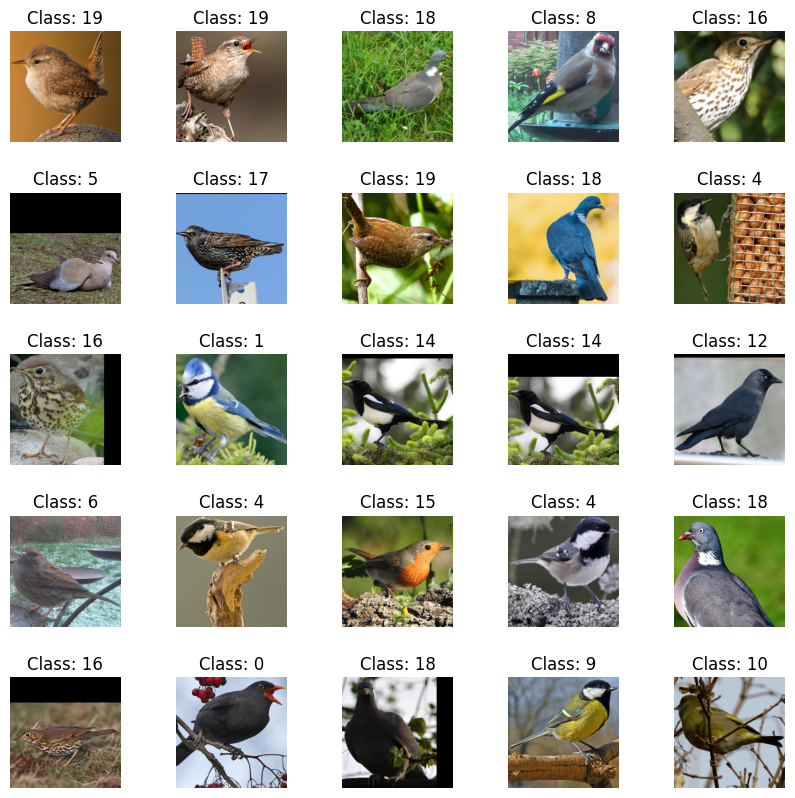

In [ ]:
tmp_train_generator = datagen.flow_from_directory(train_ds,
                                              target_size=(img_size, img_size), 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              class_mode='categorical',
                                             )  

# same as preprocess function above but does not perform shape permutation
def tmp_preprocess_image(image):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, dtype=tf.float32)
    return image
    
#Display a grid of 25 sample training images with corresponding class labels.
num_images_to_show = 25
images_shown = 0
plt.figure(figsize=(10, 10))

while images_shown < num_images_to_show:
    sample_generate = next(tmp_train_generator, None)
    if sample_generate is None:
        break
    images = sample_generate[0]
    titles = sample_generate[1]
    batch_size = images.shape[0]
    for i in range(min(batch_size, num_images_to_show - images_shown)):
        plt.subplot(5, 5, images_shown + 1)
        plt.subplots_adjust(hspace=0.3, wspace=0.5)
        plt.imshow(tmp_preprocess_image(images[i]))
        plt.title(f'Class: {labels[np.argmax(titles[i], axis=0)]}')
        plt.axis("off")
        images_shown += 1

plt.show()

In [ ]:
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 3, restore_best_weights=True, verbose = 1) 

training_stats_callback = TrainingStatsCallback() 

callbacks=[checkpoint,earlystopping, training_stats_callback]

In [ ]:
def train_model(model, model_name, train_generator, validation_generator, callbacks, epochs=100):
    history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=validation_generator,
                    callbacks=callbacks
                   )
    
    # Save the model and its weights
    model.save(f'{model_name}.keras')
    model.save_weights(f'{model_name}_weights.h5')
    return history

In [76]:
def evalute_model(history, model, test_generator, epochs_trained):
    show_training_plots(history)
    
    #Show training time/ number of epochs
    hours, minutes, seconds, epochs_trained = get_train_duration()
    print("Training Time: {} hours, {} minutes, {} seconds".format(hours, minutes, seconds))
    print("Number of Epochs Trained:", epochs_trained)

    #Make predictions on test data
    indices, filenames, y_val, y_pred = get_predictions(model,test_generator)
    test_df = get_predictions_df(indices, filenames, y_val, y_pred)

    correctly_classified, c_titles = gradcam_of_images(correct_class=True)
    misclassified, m_titles = gradcam_of_images(correct_class=False)

    num_true_img = get_max_true_img()
    num_false_img = get_max_false_img()

    display_heatmaps(correctly_classified,c_titles,num_true_img)

    display_heatmaps(misclassified,m_titles,num_false_img)

In [65]:
EPOCHS = 100
LEARNING_RATE = 1e-4

In [74]:
history = train_model(model, 'ViT-google-small', train_generator, validation_generator, callbacks, epochs=EPOCHS)

Epoch 1/100
249/249 [==============================] - ETA: 0s - loss: 0.0564 - accuracy: 0.9804
Epoch 1: val_loss improved from 0.21869 to 0.14672, saving model to WinKawaks\vit-small-patch16-224
INFO:tensorflow:Assets written to: WinKawaks\vit-small-patch16-224\assets


INFO:tensorflow:Assets written to: WinKawaks\vit-small-patch16-224\assets


249/249 [==============================] - 709s 3s/step - loss: 0.0564 - accuracy: 0.9804 - val_loss: 0.1467 - val_accuracy: 0.9682
Epoch 2/100
249/249 [==============================] - ETA: 0s - loss: 0.0157 - accuracy: 0.9940
Epoch 2: val_loss did not improve from 0.14672
249/249 [==============================] - 675s 3s/step - loss: 0.0157 - accuracy: 0.9940 - val_loss: 0.1987 - val_accuracy: 0.9541
Epoch 3/100
249/249 [==============================] - ETA: 0s - loss: 0.0222 - accuracy: 0.9919
Epoch 3: val_loss improved from 0.14672 to 0.11142, saving model to WinKawaks\vit-small-patch16-224
INFO:tensorflow:Assets written to: WinKawaks\vit-small-patch16-224\assets


INFO:tensorflow:Assets written to: WinKawaks\vit-small-patch16-224\assets


249/249 [==============================] - 694s 3s/step - loss: 0.0222 - accuracy: 0.9919 - val_loss: 0.1114 - val_accuracy: 0.9788
Epoch 4/100
103/249 [===========>..................] - ETA: 6:07 - loss: 0.0014 - accuracy: 1.0000

KeyboardInterrupt: 

In [ ]:
# Keyboard Interrupted because too long and good enough for now

In [78]:
evalute_model(history, model, test_generator, EPOCHS)

NameError: name 'history' is not defined

## SAVE MODEL

In [ ]:
# Save the model and its weights
model.save('ViT-google-small.keras')
model.save_weights('ViT-google-small_weights.h5')

## TRAINING PLOTS

In [ ]:
#Show training acuracy and loss plots
show_training_plots(history)

In [79]:
#Show training time/ number of epochs
hours, minutes, seconds, epochs_trained = get_train_duration()
print("Training Time: {} hours, {} minutes, {} seconds".format(hours, minutes, seconds))
print("Number of Epochs Trained:", epochs_trained)

Training Time: 0 hours, 39 minutes, 46 seconds
Number of Epochs Trained: 3


## MODEL EVALUATION

72/72 [==============================] - 180s 2s/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       0.97      1.00      0.98        30
           2       1.00      1.00      1.00        27
           3       0.97      1.00      0.98        30
           4       0.97      0.93      0.95        30
           5       0.97      1.00      0.98        30
           6       1.00      0.93      0.97        30
           7       1.00      1.00      1.00        19
           8       1.00      1.00      1.00        30
           9       0.93      0.93      0.93        30
          10       1.00      1.00      1.00        30
          11       1.00      0.97      0.98        30
          12       1.00      1.00      1.00        27
          13       1.00      1.00      1.00        30
          14       1.00      1.00      1.00        19
          15       1.00      0.97      0.98        30
          16       0.97    

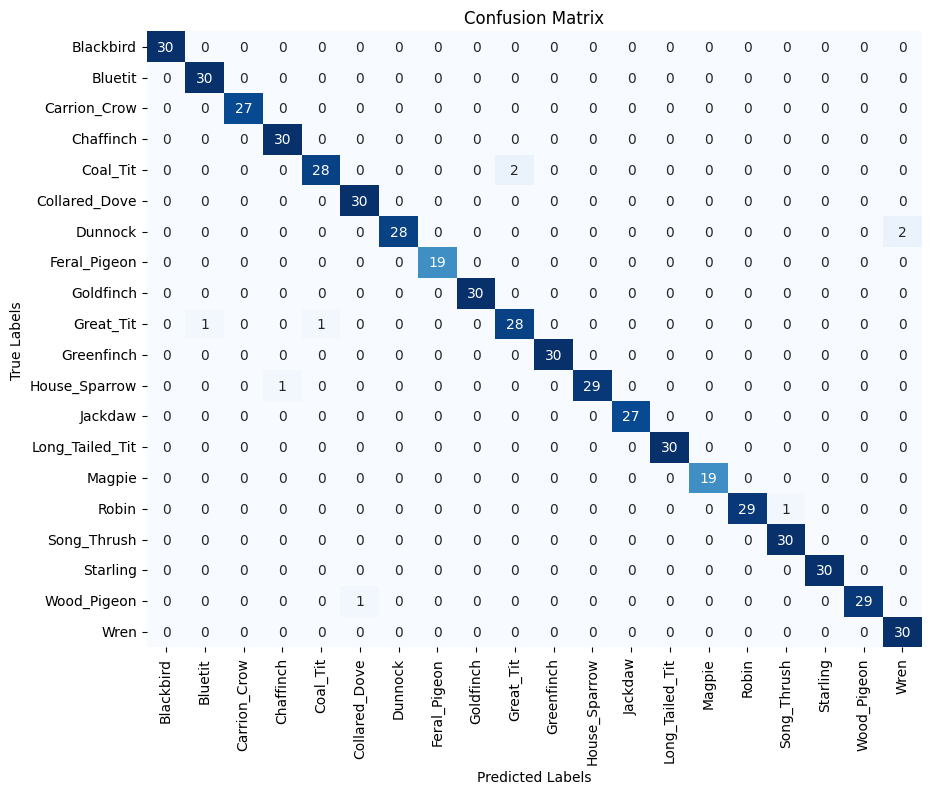

In [80]:
#Make predictions on test data
indices, filenames, y_val, y_pred = get_predictions(model,test_generator)
test_df = get_predictions_df(indices, filenames, y_val, y_pred)

## TEST PREDICTION HEAT MAPS

In [87]:
print(vit_model.layers[0].layers)

AttributeError: 'TFViTMainLayer' object has no attribute 'layers'

In [ ]:
# cant do gradcam like for ResNet because this pretrained ViT model does not have the same architecture

In [81]:
correctly_classified, c_titles = gradcam_of_images(correct_class=True)
misclassified, m_titles = gradcam_of_images(correct_class=False)

ValueError: No such layer: conv5_block3_3_conv. Existing layers are: ['input_4', 'lambda_3', 'tf.convert_to_tensor_3', 'tf_vi_t_for_image_classification_1', 'reshape_3', 'global_average_pooling2d_3', 'dense_6', 'dense_7'].

In [ ]:
num_true_img = get_max_true_img()
num_false_img = get_max_false_img()

## CORRECT PREDICTIONS

In [ ]:
display_heatmaps(correctly_classified,c_titles,num_true_img)

## INCORRECT PREDICTIONS

In [ ]:
display_heatmaps(misclassified,m_titles,num_false_img)